# Basic Data Cleaning and Transformation
(Add description here)

[Factors of Academic Success Survey](https://forms.gle/vJcqWct3swRasCbAA "Link to Google Forms")


#### The two demographics that were surveyed:
- A Drum Corps Facebook Page
- People and friends who follow me on my social media accounts

## Importing libraries and survey results

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import re
import os

#### Read survey spreadsheets

In [2]:
os.chdir("Google Forms Spreadsheets")

for _, _, filenames in os.walk(os.getcwd()):
    surveydata = pd.read_excel(filenames[0])
    for f in filenames[1:]:
        surveydata = pd.merge(left=surveydata, right=pd.read_excel(f), how="outer")

surveydata.columns = map(str.lower, surveydata.columns)

### Calculate the average amount of sleep for each person

In [3]:
def clean_bed_times(column, dataf=surveydata):
    """
    Corrects incorrect AM/PM selection for given column name
    
    Accepts string and DataFrame (default: surveydata)
    Returns dt.time Series
    
    """
    if column == "go_to_bed":
        return pd.Series([dt.time(np.abs(time.hour - 12), time.minute, 0) 
                          if 6 < time.hour < 18 
                          else time 
                          for time in dataf[column]])
    
    elif column == "up_from_bed":
        return pd.Series([dt.time(np.abs(time.hour - 12), time.minute, 0) 
                          if time.hour > 18 
                          else time 
                          for time in dataf[column]])
    
surveydata["go_to_bed"], surveydata["up_from_bed"] = clean_bed_times("go_to_bed"), clean_bed_times("up_from_bed")


def time_to_datetime(column, dataf=surveydata):
    """
    Converts dt.time values to dt.datetime values based on the bedtime or waketime
    
    Accepts string and DataFrame (default: surveydata)
    Returns dt.datetime Series

    """
    # Insert date
    time_day = pd.Series(["2000/01/02 " 
                          if (column == 'up_from_bed' or (column == 'go_to_bed' and dataf[column][i].hour < 5)) 
                          else "2000/01/01 " 
                          for i in range(dataf.shape[0])]).astype(str)
    
    # Convert time values to strings
    time_time = dataf[column].astype(str)
    
    # Concat date and time and convert to datetime object    
    return (time_day + time_time).apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))

# Calculate and insert column into the dataset and convert timedelta to hours
surveydata.insert(23, 'avg_sleep_hours', (time_to_datetime('up_from_bed') - time_to_datetime('go_to_bed')).apply(lambda x: x.seconds / 3600))

### Map college majors column into seperate categories

In [4]:
# For some reason my regex lookaheads and lookbehinds wont work, something to figure out later
surveydata.insert(5, 'major_cat', surveydata.major.fillna("Undecided"))

mapping_majors = {"Undecided":r"general|no\sclue|undecided", "Medical":r"medi|pharmacy|nursing", "Music":r"music", "Business":r"account|manage|info", 
                  "Science":r"zoo|biology|physical|animal|agri|kinesi|science", "Technology":r"tech|computer(?!info)", 
                  "Engineering":r"(?<!medical)engineer|aviation", "Math":r"data|physics|math|economics",
                  "Fine Arts":r"art|picture|culinary|history|tourism|soci|child", "Trades":r"welding"}

for cat in ["Undecided", "Medical", "Music", "Business", "Science", "Technology", "Engineering", "Math", "Fine Arts", "Trades"]:
    surveydata.loc[surveydata.major_cat.str.contains(mapping_majors[cat], flags=re.IGNORECASE), 'major_cat'] = cat

### Compare SAT and ACT scores and keep the highest one as a converted SAT score

In [5]:
def act_to_sat(act):
    """
    Converts given ACT test score to equivalent SAT test score
    
    Accepts string, int, float, or np.NaN
    Returns int or np.NaN
    
    """
    act_sat = {'36':1590, '35':1540, '34':1500, '33':1460, '32':1430, '31':1400, '30':1370, '29':1340, '28':1310, '27':1280, '26':1240, '25':1210, '24':1180, '23':1140, '22':1110, '21':1080, '20':1040, '19':1010, '18':970}
    if np.isnan(act):
        return np.NaN
    else:
        score = str(int(act))
        if score in act_sat:
            return act_sat[score]
        else:
            return np.NaN
        
# Insert column and clean values
surveydata.insert(11, 'converted_sat', surveydata.act.apply(act_to_sat))
surveydata[['converted_sat', 'sat']] = surveydata[['converted_sat', 'sat']].fillna(0).astype(int)

# Keep highest score as converted SAT score
rows = (surveydata.sat > surveydata.converted_sat)
surveydata.loc[rows, 'converted_sat'] = surveydata.loc[rows, 'sat'].copy()

### Set low values in all numeric cells to np.NaN

In [6]:
columns = ["college_gpa", "sat", "converted_sat", "act", "iq"]
surveydata[columns] = surveydata[columns].applymap(lambda x: x if x > 1 else np.NaN)

### Format MBTI types to correct input errors

In [7]:
def clean_myers_briggs(mbti):
    """
    Cleans Myers-Briggs string to capitalize and place letters in correct order
    
    Accepts string or np.NaN
    Returns string or np.NaN

    """
    try:
        mbti = mbti.upper()
    except AttributeError:
        return np.NaN
    return re.findall(r'E|I', mbti)[0] + re.findall(r'S|N', mbti)[0] + re.findall(r'T|F', mbti)[0] + re.findall(r'P|J', mbti)[0]
    
surveydata.myers_briggs = surveydata.myers_briggs.apply(clean_myers_briggs)

### Create unique columns for elements in list columns

In [8]:
def expand_series_of_lists(in_series):
    """
    Creates seperate boolean columns for each unique list value in Series
    
    Accepts list Series
    Returns bool DataFrame
    
    """
    
    unique_elements = []
    in_series = in_series.fillna("")
    clean_str = lambda x: x.strip().lower().replace(' ', '_')
    
    # Create a list of unique values throughout all cells in column
    for row in in_series:
        unique_elements.extend([clean_str(element) for element in row if clean_str(element) not in unique_elements])
        
                
    def create_bool_series(cell, unique):
        for element in cell:
            if unique == clean_str(element):
                return True
            else:
                pass
        return False
        
    out_dataf = pd.DataFrame()
    for u_element in unique_elements:
        out_dataf.insert(0, u_element, in_series.apply(lambda x: create_bool_series(x, unique=u_element)))
        
    # reverse order of columns
    return out_dataf[out_dataf.columns.tolist()[::-1]]

# Convert list cells to lists
columns = ['self_improv', 'activities', 'watched_media']
surveydata[columns] = surveydata[columns].apply(lambda x: x.str.split(","))

for column in columns:
    surveydata = pd.concat([surveydata, expand_series_of_lists(surveydata[column])], axis=1)

surveydata = surveydata.drop(columns, axis=1)

### rename column names to make data exploration less tedious

In [9]:
#colnames = surveydata.columns.tolist()

####################
mapping_columns = {'i_have_a_consistent_morning_routine':'routine', 'i_exercise_on_a_regular_basis':'exercise', 
                     'i_try_to_maintain_a_healthy_diet':'diet', 'i_try_to_limit_my_use_of_social_media':'limits_social_media', 
                     'i_participate_in_nofap':'nofap', 'i_keep_a_journal_for_things_like_time_management_|_personal_development/goals_|_and_idea/project_notes':'planner', 
                     "i_keep_a_diary_for_things_like_analyzing_the_day's_activities_|_tracking_mental_health_|_and_self_reflection.":'diary',
                     'i_drink_energy_drinks_on_a_semi-regular_basis':'energy_drinks', 'i_practice_meditation':'meditation', 'i_take_cold_showers':'cold_showers', 
                     'i_keep_a_planner_for_things_like_time_management_|_personal_development/goals_|_and_idea/project_notes':'planner2', 
                     "i_keep_a_journal/diary_for_things_like_analyzing_the_day's_activities_|_tracking_mental_health_|_and_self_reflection.":'diary2', 
                     'i_drink_coffee_on_a_semi-regular_basis?':'coffee2', 'i_drink_coffee_on_a_semi-regular_basis':'coffee', 'gaming_/_mtg_/_dnd_group':'gaming_club', 
                     'drum_corps':'drum_corps', 'physical_sport_(hockey_|_soccer_|_etc.)':'plays_sports','theater_/_drama_club':'theater',
                     'nature_hobby_(fishing_|_camping_|_etc.)':'nature_hobby','school_band_(concert_|_jazz_|_marching)':'school_band','indoor_drumline':'indoor_drumline',
                     'stem_club_(robotics_|_it_|_etc)':'stem_club','indoor_drumline_/_wgi':'indoor_drumline2','drum_corps_/_dci':'drum_corps2'}
####################

surveydata = surveydata.rename(columns=mapping_columns)

### Convert (Yes, No) to (True, False)

In [10]:
columns = ["social_awkward", "social_anxious", "show_up_early", "cluttered", "share_posts_often", "depressed"]
for column in columns:
    surveydata[column] = surveydata[column].map({"Yes":True, "No":False})

### Combine duplicate columns (coffee = coffee2, etc)

In [11]:
# Duplicate columns have been differentiated by appending "2"
for column in ["coffee", "drum_corps", "indoor_drumline", "planner", "diary"]:
    surveydata[column] = surveydata[[column, column + "2"]].any(axis=1)
    surveydata = surveydata.drop([column + "2"], axis=1)

### Drop data points that are either rare or likely irrelevent
(>50 columns is going to be impractical to work with)

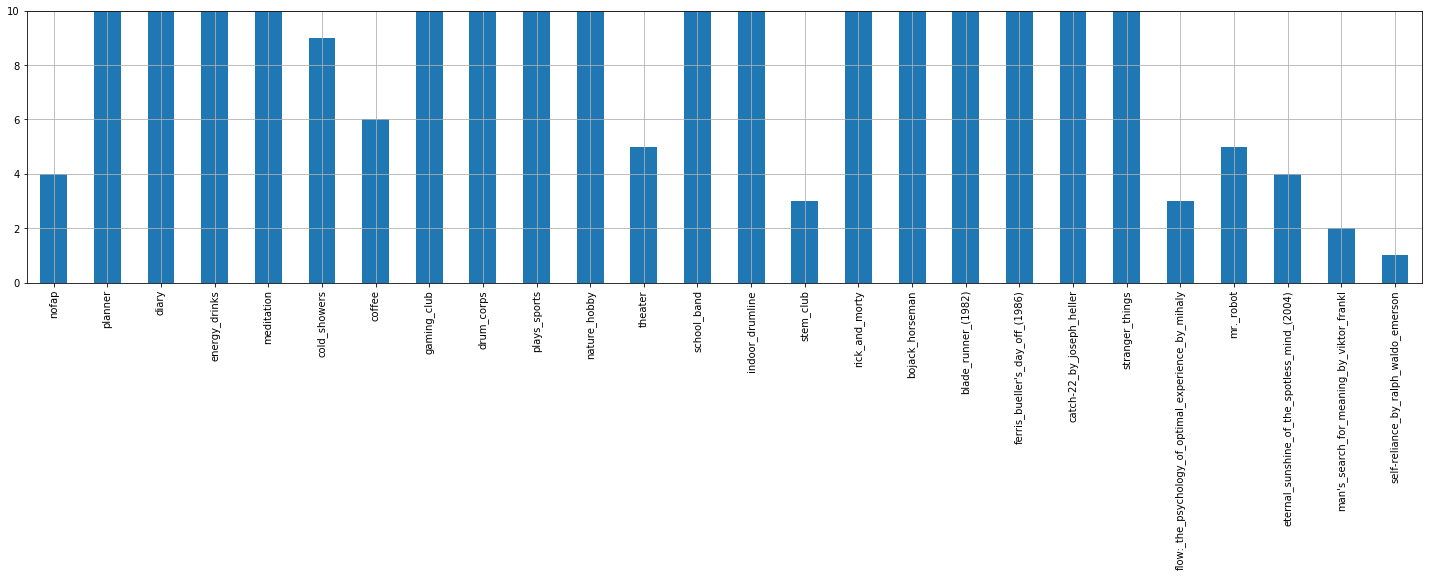

In [21]:
surveydata.sum(numeric_only=True)["nofap":].plot(kind="bar", ylim=(0,10), figsize=(25,5), grid=True)

In [ ]:
#colsums = surveydata.sum() #put in jupiter notebook to demonstrate need to drop low sum boolean columns (6 = lower bound) (use thresh=6? not sure how to write that yet)
surveydata = surveydata.drop(['nofap','theater','gaming_club','stem_club','diary','flow:_the_psychology_of_optimal_experience_by_mihaly', 'mr._robot',
                              'eternal_sunshine_of_the_spotless_mind_(2004)', "man's_search_for_meaning_by_viktor_frankl", 'self-reliance_by_ralph_waldo_emerson'], axis=1)


### Set missing values from datasets to NaN (instead of False)

In [ ]:
# Find out why coffe datatype isn't boolean after following line:
surveydata.loc[surveydata["survey_loc"] == "Implying Dum corps: electric boogaloo", "coffee"] = np.NaN

### Convert first 36 big5 personality score rows to range 1-5 (from range 1-10)

In [ ]:
def clean_big5(score):
    """
    Compresses the range of given positive numberic values by two
    
    Accepts int or float
    Returns int (greater than 0)

    """
    score = score//2
    return score if score != 0 else 1

columns = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
surveydata.iloc[0:36][columns] = surveydata.iloc[0:36][columns].applymap(clean_big5).copy()

# Export data to json, excel, and csv formats

```python
if not os.path.exists("../Cleaned JSON and XLSX"):
    os.mkdir("../Cleaned JSON and XLSX")
    
os.chdir("../Cleaned JSON and XLSX")

surveydata.set_index("timestamp", inplace=True)

surveydata.to_json("surveydata.json", orient="records", lines=True, indent=4)
surveydata.to_excel("surveydata.xlsx")
os.chdir("../")
surveydata.to_csv("surveydata.csv")
```